In [1]:
import numpy as np
import pandas as pd
from debiasm.sklearn_functions import AdaptationDebiasMClassifier
from debiasm.torch_functions import rescale
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon
import torch

In [2]:
def experiment_run(samples_,
                   n_studies, 
                   n_per_study,
                   n_features,
                   phenotype_std,
                   read_depth, 
                   bcf_stdv = 2, 
                   linear_weights_stdv = 2,
                   seed=0):
    
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    
    # drop samples/features not needed for this run
    samples=samples_.sample(n=n_studies * n_per_study, 
                           replace=False)\
                .T.sample(n=n_features, replace=False).T
    
    ## simulated bcfs
    true_bcfs = np.random.normal(scale=bcf_stdv,
                                 size = (n_studies, n_features)
                                 )
    
    ## simulated linear weights
    true_weights = np.random.normal(scale=linear_weights_stdv, 
                                    size = n_features
                                    )

    ## simulated phenotypes
    phenotypes = samples @ true_weights[:, np.newaxis]
    if phenotype_std > 0:
        phenotypes += np.random.normal(scale = phenotype_std,
                                       size=phenotypes.shape)
    
    studies = pd.Series( [ i // n_per_study for i in range(samples.shape[0]) 
                                     ] , 
                        index=samples.index, 
                        name='studies')

    samples_transformed = ( rescale( samples *\
                                    np.power(2, true_bcfs)[studies] 
                                    )*read_depth
                              ).astype(int)
    
    dm = AdaptationDebiasMClassifier()
    dm.fit(X=pd.concat([studies, samples_transformed], axis=1 ).values, 
           y=phenotypes.values[:, 0] > phenotypes.median().values[0]    
          )
    
    transformed_jsds = jensenshannon(dm.transform(pd.concat([studies,
                                      samples_transformed], 
                                     axis=1 )
                          ).T,
              samples.T)

    baseline_jsds = jensenshannon(samples_transformed.T, samples.T)
    n_samples = samples.shape[0]

    if type( read_depth ) == np.ndarray:
        read_depth=1e4
        
    if type(bcf_stdv)==np.ndarray:
        bcf_stdv='varied'
        
    
    
    summary_df = pd.DataFrame({'Group':['Baseline']*n_samples +\
                                               ['DEBIAS-M']*n_samples,
                               'JSD':list(baseline_jsds**2) +\
                                           list(transformed_jsds**2),
                               'N_studies':n_studies, 
                               'N_per_study':n_per_study, 
                               'N_features':n_features, 
                               'Pheno_noise':phenotype_std, 
                               'Read_depth':read_depth, 
                               'BCF_std':bcf_stdv,
                               'run_num':seed
                              })
    
    run_description = '_'.join( [a.replace('_', '-') + '-' + str(b)
                                 for a,b in 
                                   {'N_studies':n_studies, 
                                   'N_per_study':n_per_study, 
                                   'N_features':n_features, 
                                   'Pheno_noise':phenotype_std, 
                                   'Read_depth':int(read_depth), 
                                   'BCF_std':bcf_stdv,
                                   'run_num':seed}.items()]
                                )
    return(summary_df, run_description, true_bcfs, dm)

In [3]:
all_true_bcfs = []
all_fitted_bcfs = []
all_results = []

for n_features in [10]:
    for n_studies in [2,3,4]:
        for n_per_study in [24, 48, 72, 96]:
            for phenotype_std in [0.1, 1, 10]:
                for read_depth in [1e3, 1e4, 1e5]:
                    if read_depth==1e4 or\
                        phenotype_std==0.1 or\
                        n_per_study==96 or\
                        n_studies==4:
                    
                    
                        for seed in range(1,26):
                            print(seed)
                            data = pd.read_csv('generated-100-feat-datasets/dataset-seed-{}.csv'.format(seed), 
                                              index_col=0)+1e-4

                            results, run_desc, true_bcfs, dm = \
                                                experiment_run(data,
                                                               n_studies, 
                                                               n_per_study,
                                                               n_features,
                                                               phenotype_std,
                                                               read_depth, 
                                                               bcf_stdv = 2, 
                                                               seed=seed
                                                               )


                            all_true_bcfs.append( np.power(2,
                                                 true_bcfs
                                                ) )
                            all_fitted_bcfs.append(1./np.power(2, 
                                                   dm.model.batch_weights.detach().numpy()
                                                  ))

                            all_results.append(results)

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

1


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

2


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

7


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

12


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

18


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

21


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

22


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

25


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

1
2


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

7


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11
12


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

15


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

18


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

22


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

25


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

1


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

2


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

7


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

12


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

15


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

18


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

22


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

25


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

2


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

5


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

7


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

8


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

10


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

12


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

15


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

21


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

22


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

25


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

1


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

2


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

5


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

7


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

8


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

10


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

12


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

15


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

21


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

22


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

24


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

25


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

7


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

12


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

17


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

18


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

21


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

23


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

24


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

7


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

12


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

17


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

18


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

21


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

23


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

24


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

7


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

12


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

17


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

18


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

21


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

23


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

24


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

10


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

10


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

20


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

21


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

22


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

23


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

9


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

20


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

21


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

22


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

23


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

24


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

20


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

21


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

22


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

23


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

24


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

2


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

10


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

20


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

24


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

2


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

10


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

15


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

20


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

21


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

24


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

20


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

21


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

24


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

2


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

20


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

21


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

24


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

2


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

10


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

15


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

2


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

10


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

15


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

2


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

10


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

15


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

2


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

10


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

15


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

2


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

10


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

15


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

2


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

10


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

15


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

7


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

12


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

13


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

7


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

12


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

13


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

7


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

12


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

13


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

10


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

1


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

5


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

6


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

21


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

1


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

5


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

6


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

21


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

1


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

5


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

6


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

21


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

12


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

1


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

10


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

6


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

12


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

21


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

22


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

23


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

6


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

7


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

12


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

21


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

22


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

23


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

5


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

6


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

7


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

12


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

21


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

22


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

23


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

2


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

10


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

2


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

12


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

13


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

15


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

20


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

21


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

22


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

24


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

25


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

2


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

12


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

13


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

15


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

20


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

21


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

22


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

24


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

25


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

2


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

12


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

13


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

15


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

20


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

21


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

22


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

24


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

25


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

2


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

8


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

13


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

15


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

20


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

2


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

8


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

13


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

15


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

20


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

2


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

8


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

13


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

15


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

20


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

10


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

15


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

10


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

15


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

5


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

10


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

15


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

7


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

8


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

13


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

16


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

18


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

24


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

25


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

1


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

7


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

8


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

13


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

16


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

18


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

24


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

25


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

1


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

7


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

8


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

13


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

16


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

18


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

24


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

25


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

1


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

8


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

10


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

13


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

16


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

24


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

25


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

1


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

8


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

10


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

13


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

16


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

24


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

25


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

1


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

8


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

10


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

13


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

16


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

24


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

25


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

8


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

10


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

13


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

25


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

8


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

10


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

13


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

25


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

8


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

10


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

13


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

25


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

1


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

12


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

13


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

15


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

16


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

12


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

15


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

16


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

12


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

15


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

16


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

10


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

10


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

5


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

13


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

5


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

13


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

5


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

13


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

6


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

10


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

6


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

10


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

6


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

10


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

6


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

10


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

6


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

10


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

6


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

10


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

14


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

2


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

17


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

21


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

24


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

2


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

13


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

17


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

21


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

24


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

2


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

13


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

17


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

21


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

24


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

13


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

24


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

25


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

13


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

24


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

25


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

13


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/User

24


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

10


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

10


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

1


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

2


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

3


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

4


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

5


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

6


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

10


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: Lightni

11


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

13


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

15


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

16


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

17


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

18


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

19


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

20


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

21


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

22


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

23


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(ena

24


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.p

25


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

In [4]:
len(all_fitted_bcfs)

2100

In [5]:
from scipy.stats import spearmanr
import numpy as np

In [7]:
v1=np.random.rand(10)
v2=np.random.rand(10)
print( spearmanr(v1, v2) )
print( spearmanr(100+v1, v2) )

SpearmanrResult(correlation=0.43030303030303024, pvalue=0.21449233253280775)
SpearmanrResult(correlation=0.43030303030303024, pvalue=0.21449233253280775)


In [22]:
len( all_results )

2100

In [6]:
all_mean_spearmans= [ np.mean( [ spearmanr(
                                        all_fitted_bcfs[i][j],
                                        all_true_bcfs[i][j]
                                ).correlation
                        for j in range(all_true_bcfs[i].shape[0]) ] )
                        for i in range(len(all_true_bcfs))
                      ] 

In [7]:
arprep= pd.concat([ all_results[i].iloc[:1, 2:]
                    for i in range(len(all_results)) ])

arprep['Spearman R'] = all_mean_spearmans

In [24]:
arprep.to_csv('../plots/Revision_simulations/bcf-spearmanr-plots/all-bcf-spearmanr-results.csv')


In [ ]:
[a for a in np.linspace(0, 1, 6) 
if a > res['Spearman R'].min() and a < res['Spearman R'].max()]

In [31]:
def process_for_pearsonr_plot(full_df, 
                               x_val):
    
    res=full_df.copy()
#     res=pd.read_csv(pth, index_col=0)
    res=res.loc[res.Pheno_noise>0]
#     res=res.loc[res.Pheno_noise<10]
    
    default_vals = pd.DataFrame({'N_studies':4, 
                                 'Pheno_noise':0.1, 
                                 'Read_depth':1e4, 
                                 'N_features':10, 
                                 'N_per_study':96
                                 }, 
                                index=[0]
                               )

    res = res.merge(default_vals.drop(x_val, axis=1))

    res = res.groupby( list( res.columns.drop('Spearman R').values) 
                               )['Spearman R'].median().reset_index()

    qq=res.copy()
    
    
    plt.figure(figsize=(8,8))
    ax=sns.boxplot(y='Spearman R', 
                x=x_val,
                data = qq.reset_index(), 
                fliersize=0,
                color=plotting.global_palette['debias-m']
               )

    sns.swarmplot(
                  y='Spearman R', 
                  x=x_val,
                  data = qq.reset_index(),
                  color='black',
                  s=5,
                  dodge=True, 
                  ax=ax
                )
    
    
    plt.yticks([a for a in np.linspace(0.1, .9, 9) 
                if a > res['Spearman R'].min() - .1
                and a < res['Spearman R'].max()])
    
    if res['Spearman R'].min() < .4:
        plt.yticks([a for a in np.linspace(0.1, .9, 5) 
                if a > res['Spearman R'].min() - .1
                and a < res['Spearman R'].max()])
    
    
    plt.legend().remove()
    return(ax)

In [70]:
!mkdir ../plots/Revision_simulations/bcf-spearmanr-plots/

No handles with labels found to put in legend.


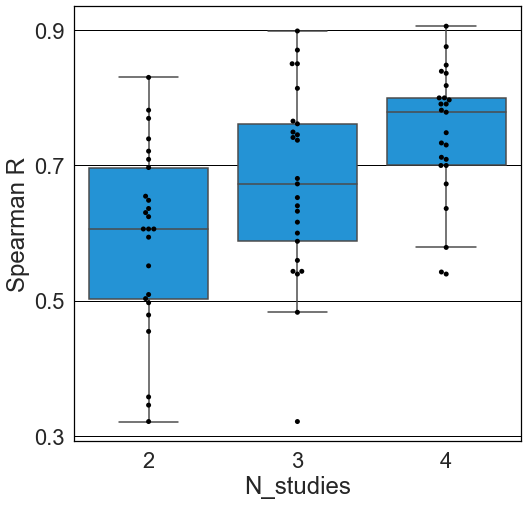

No handles with labels found to put in legend.


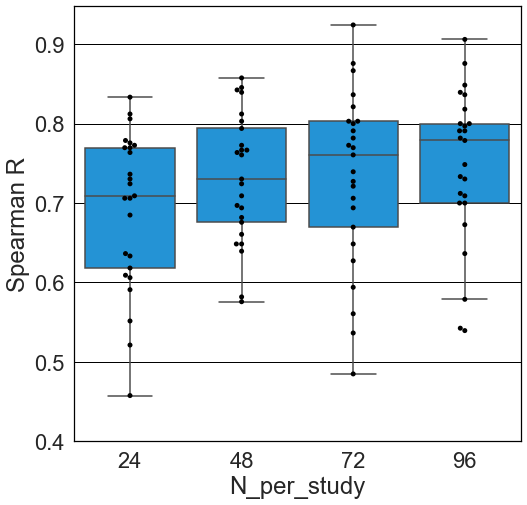

No handles with labels found to put in legend.


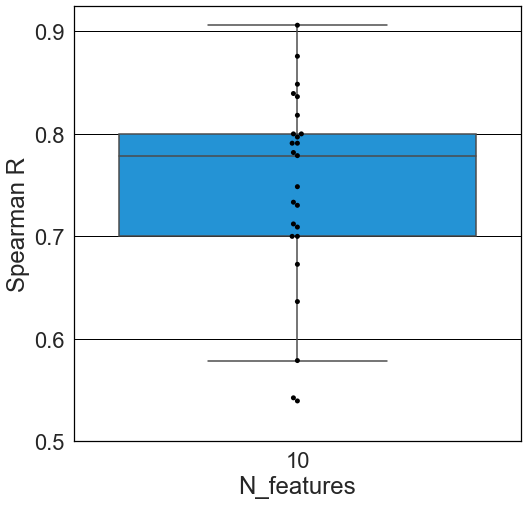

No handles with labels found to put in legend.


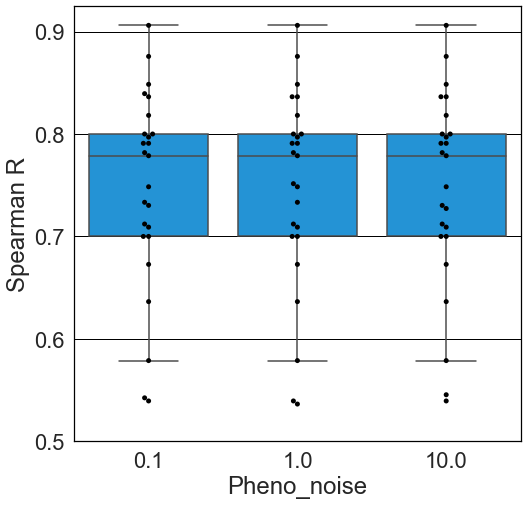

No handles with labels found to put in legend.


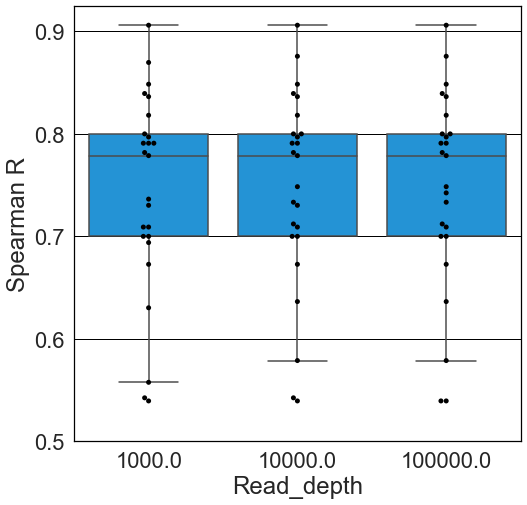

In [32]:
for a in arprep.columns[:5]:
    process_for_pearsonr_plot(arprep, a)
    plt.savefig('../plots/Revision_simulations/bcf-spearmanr-plots/bcf-{}.pdf'.format(a), 
                format='pdf', 
                bbox_inches='tight', 
                dpi=900
                )
    plt.show()

In [10]:
import sys
sys.path.append('../v1-DEBIAS-M-Analysis/')
from General_functions import plotting

def flatten(xss):
    return [x for xs in xss for x in xs]

In [11]:
from sklearn.preprocessing import StandardScaler

In [19]:
ss=StandardScaler()

ss.fit_transform( np.log2(all_fitted_bcfs[0].T )).T#.shape#[:, np.newaxis]) )

array([[ 0.927145  ,  2.0188935 , -1.796216  , -0.42655137, -0.41216815,
         0.40221804,  0.74448174, -0.68603736, -0.35621843, -0.4155469 ],
       [ 1.8059269 , -0.48993522, -0.9755301 , -0.17384095,  1.2610714 ,
         0.8575461 , -0.34496045,  0.453871  , -1.202295  , -1.1918539 ],
       [-0.5626993 , -2.7007346 ,  0.445719  ,  1.0500603 , -0.2684287 ,
         0.18578382,  0.18691579,  0.5677325 ,  0.6574992 ,  0.43815202],
       [ 1.8550932 , -0.47009468,  1.828717  , -0.470127  , -1.1174432 ,
        -0.3950988 ,  0.36467192, -0.02941584, -0.84285533, -0.72344744]],
      dtype=float32)

In [ ]:
ss.fit_transform( np.log2( a.T )).T

In [20]:

q1=flatten( flatten( [
                    np.power(2, ss.fit_transform( np.log2( a.T )).T )
                      for a in all_true_bcfs] ))



q2=flatten( flatten( [
                    np.power(2, ss.fit_transform( np.log2( a.T )).T )
                      for a in all_fitted_bcfs] ))



In [28]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


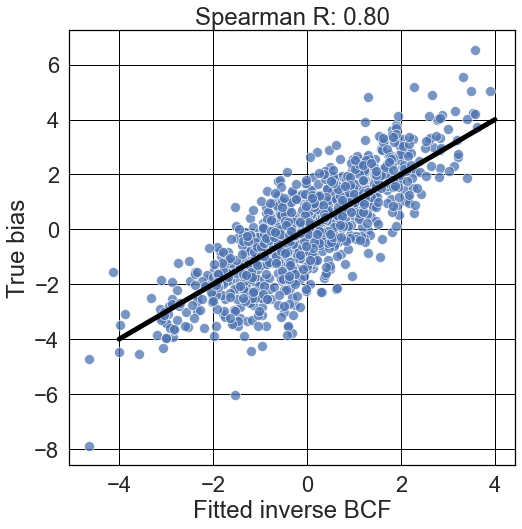

In [51]:
q1_=flatten( flatten(all_true_bcfs) )
q2_=flatten( flatten(all_fitted_bcfs) )

q1=flatten( flatten(all_true_bcfs) )
q2=flatten( flatten(all_fitted_bcfs) )

# q1=flatten( flatten( [a/a.mean(axis=1)[:, np.newaxis] for a in all_true_bcfs] ))
# q2=flatten( flatten( [a/a.mean(axis=1)[:, np.newaxis] for a in all_fitted_bcfs] ))


# q1=flatten( flatten( [
#                     np.power(2, ss.fit_transform( np.log2( a.T )).T )
#                       for a in all_true_bcfs] ))



# q2=flatten( flatten( [
#                     np.power(2, ss.fit_transform( np.log2( a.T )).T )
#                       for a in all_fitted_bcfs] ))


q1=flatten( flatten( [
                    np.power(2, np.log2(a) - np.log2(a).mean(axis=1)[:, np.newaxis] )
                      for a in all_true_bcfs] ))



q2=flatten( flatten( [
                    np.power(2, np.log2(a) - np.log2(a).mean(axis=1)[:, np.newaxis] )
                      for a in all_fitted_bcfs] ))



plt.figure(figsize=(8,8))
ax=sns.scatterplot(
                y = np.log2( np.array(q1)[np.array(q2_)!=1] ),
                x = np.log2( np.array(q2)[np.array(q2_)!=1] ), 
                s=100, 
                alpha=.75
                )

sns.lineplot([-4, 4], [-4, 4],
            ax=ax, 
            linewidth=5, 
            color='black')

plt.title('Spearman R: {:.2f}'.format(
                        spearmanr(np.array(q1)[np.array(q2_)!=1],
                                  np.array(q2)[np.array(q2_)!=1]
                                  ).correlation))



plt.xlabel('Fitted inverse BCF')
plt.ylabel('True bias')
plt.savefig('../results/Revision-simulations/BCF-estimates.pdf', 
            format='pdf', 
            dpi=900, 
            bbox_inches='tight')


In [52]:
print( r2_score(np.array(q1)[np.array(q2_)!=1],
         np.array(q2)[np.array(q2_)!=1]
         ) )

print( spearmanr(np.array(q1)[np.array(q2_)!=1],
         np.array(q2)[np.array(q2_)!=1]
         ) )


print( pearsonr(np.array(q1)[np.array(q2_)!=1],
         np.array(q2)[np.array(q2_)!=1]
         ) )

0.3481543039900742
SpearmanrResult(correlation=0.8026598471786535, pvalue=3.1424731532580867e-217)
(0.6903787121239104, 7.653562118285623e-137)
